# Santander Customer Transaction Prediction
이번 문제에서는 고객이 거래를 체결할 확률을 구하는 문제이다. 하지만 모든 데이터가 익명화 되어 있기 때문에 오로지 수치만을 가지고 예측해야 한다.

200000 x 202 이기 때문에 대용량의 데이터라고 볼 수 있다.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import seaborn as sn
import eli5
from eli5.sklearn import PermutationImportance
import pickle
from imblearn.under_sampling import CondensedNearestNeighbour

In [2]:
tr = pd.read_csv("train.csv")
tst = pd.read_csv("test.csv")

tr.shape, tst.shape

((200000, 202), (200000, 201))

In [3]:
tr.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
tr.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

## 이상치 제거
이상치 제거에는 여러 목적이 있지만 대표적으로 데이터를 표준화 하기 위해 제거 하는 경우가 있다. IQR 방식을 이용한다. 여기서는 이상치 칼럼이 2개 이상인 데이터를 삭제한다.

In [5]:
def find_rows_with_multiple_outliers(data, q1, q3):
    iqr = q3-q1
    outliers = (data < (q1 - iqr*1.5)) | (data > (q3 + iqr*1.5))
    return outliers.sum(axis=1) > 1

In [6]:
data = tr.drop(["target", "ID_code"], axis=1)
q1, q3 = data.quantile(0.25), data.quantile(0.75)
mask = find_rows_with_multiple_outliers(data, q1, q3)

mask.sum()

1556

In [7]:
no_outliers = tr.loc[~mask]

no_outliers.shape

(198444, 202)

이후 표준화를 진행한다. 표준화는 여러 방법이 있는데 대표적으로 MinMaxScaler 와 StandardScaler 가 있다. MinMaxScaler 는 각 피쳐의 최소, 최대값을 기준으로 스케일링을 하는것이고 StandardScaler 는 평균과 표준편차를 기준으로 스케일링을 하는 것이다. 이 외에도 이상치 제거를 동시에 하는 RobustScaler 가 있다.

본문에선 MinMaxScaler 를 직접 구현해본다.

In [8]:
def MinMaxScaler(data, mn, mx):
    return (data - mn) / (mx - mn)

In [9]:
data = no_outliers.drop(["ID_code", "target"], axis=1)
test_data = tst.drop(["ID_code"], axis=1)
mn, mx = data.min(), data.max()
scaled_data = MinMaxScaler(data, mn, mx)
scaled_test_data = MinMaxScaler(test_data, mn, mx)
scaled_data[["ID_code", "target"]] = no_outliers[["ID_code", "target"]]

scaled_data.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,ID_code,target
0,0.427853,0.324824,0.568059,0.388041,0.550670,0.467321,0.441783,0.594255,0.270395,0.247420,...,0.560037,0.448173,0.510975,0.300318,0.678981,0.430958,0.327658,0.560645,train_0,0
1,0.557212,0.428639,0.681235,0.410417,0.628408,0.795072,0.526350,0.500584,0.660911,0.573056,...,0.513861,0.756190,0.350211,0.765154,0.686614,0.468277,0.609546,0.605827,train_1,0
2,0.411969,0.483777,0.578061,0.599690,0.474941,0.471329,0.748994,0.414724,0.270429,0.276041,...,0.437556,0.448000,0.671183,0.881350,0.236337,0.381950,0.425833,0.582736,train_2,0
3,0.535099,0.507140,0.396562,0.546993,0.647586,0.616822,0.563741,0.428577,0.224846,0.595326,...,0.357969,0.439205,0.745555,0.418549,0.346810,0.717176,0.590016,0.443232,train_3,0
4,0.473637,0.533434,0.624133,0.504796,0.621079,0.702836,0.580196,0.622220,0.811883,0.516413,...,0.285399,0.697737,0.238801,0.393218,0.557507,0.586526,0.591416,0.446041,train_4,0


## Feature Selection
Binary Classification 문제이므로 레이블과의 상관관계를 이용하긴 어렵고, 워낙 변수가 많아 각 변수 끼리 상관관계를 보는 것은 어렵다. 따라서 변수 선택 하는 여러가지 다른 알고리즘을 이용해보자.

1. Univariate Selection

변수 별 점수를 계산하여 변수의 중요도를 계산하는 방법으로 보통 F-score 를 많이 사용한다. F-score는 분산에 따라 변하는 값이다.

여기서는 점수가 10보다 낮은 경우를 삭제하자.

2. PCA

변수가 200개나 되어서 실행시간이 오래 걸리는 문제가 생긴다. PCA 로 일부를 줄일 수 있다. 설명력을 90%로 한다.

3. Feature Importance

몇 개의 모델은 각 변수별 중요도를 가지고 있다. 예를 들어 DT의 feature importance 를 계산 할 때엔 gini 계수를 더 잘 줄이는 변수를 중요도가 높은 변수로 여긴다.

4. Permutation Importance

eli5 라이브러리에서 제공하는 Permutation Importance 를 사용 할 수 있다. 이 방법의 원리는, 먼저 특정 모델을 만들어 과적합 시키고 변수를 하나씩 뺄 때마다 나타나는 성능 손실의 정도를 통해 각 변수의 중요도를 구하는 것이다.

본문에서는 DT를 이용한다. 일반적으로 과적합 시키기 위해 DT 의 max_depth 를 설정하지 않지만, 데이터의 크기가 너무 크기 때문에 max_depth=10으로 설정하고 실행한다.

Feature Importance 와 Permutation Importance 의 결과를 보면 서로 유사한 경향을 보였다. 따라서 두개 모두에 대해서 중요도가 낮다고 나온 변수만 삭제한다.

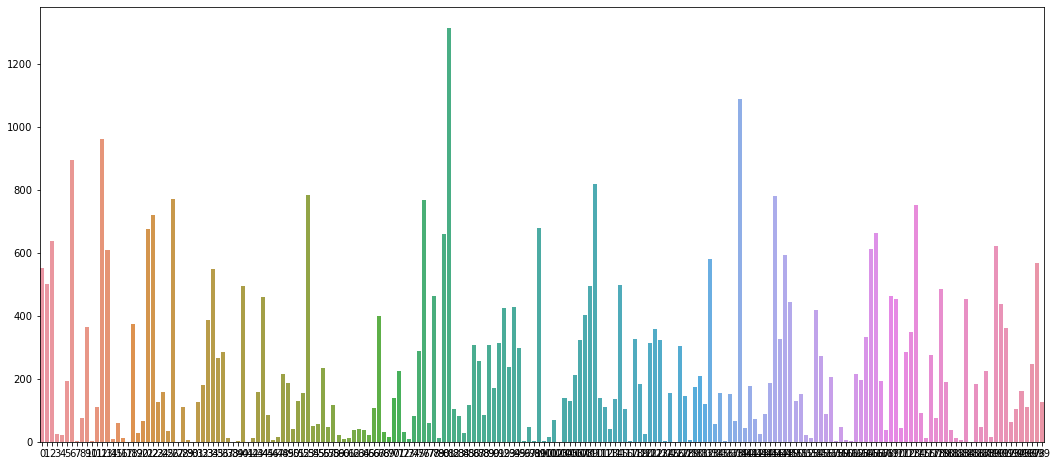

In [10]:
target = scaled_data["target"]
data = scaled_data.drop(["ID_code", "target"], axis=1)

selectK = SelectKBest(k="all")
selectK.fit(data, target)

plt.figure(figsize=(18,8))
sn.barplot(x=np.arange(len(selectK.scores_)), y=selectK.scores_)
plt.show()

In [11]:
above_10 = np.where(selectK.scores_ > 10)[0]
above_10.shape

(173,)

In [12]:
data_reduced = data.values[:, above_10]
test_data_reduced = test_data.values[:, above_10]

data_reduced.shape

(198444, 173)

In [13]:
pca = PCA(n_components=0.90)
pca.fit(data_reduced, target)
data_reduced = pca.transform(data_reduced)
test_data_reduced = pca.transform(test_data_reduced)

data_reduced.shape

(198444, 150)

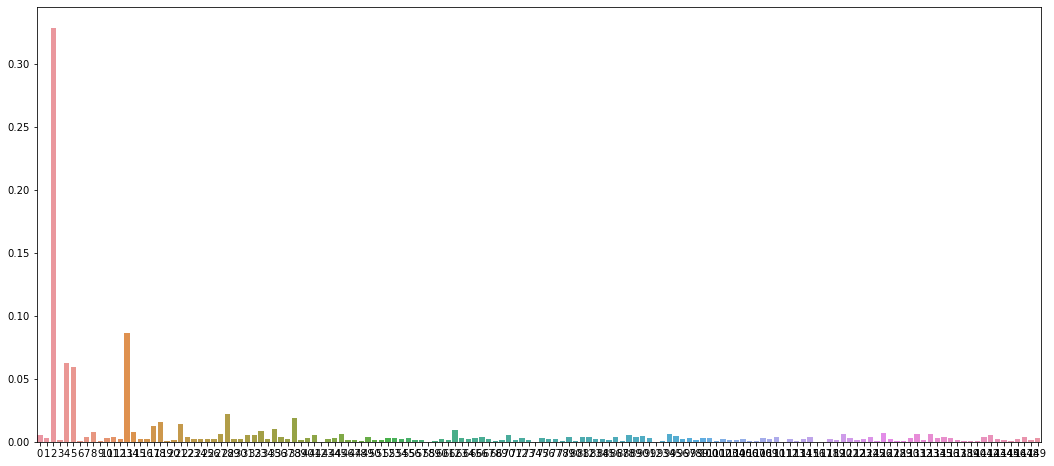

In [14]:
dt = DecisionTreeClassifier(max_depth=10).fit(data_reduced, target)

plt.figure(figsize=(18,8))
sn.barplot(x=np.arange(len(dt.feature_importances_)), y=dt.feature_importances_)
plt.show()

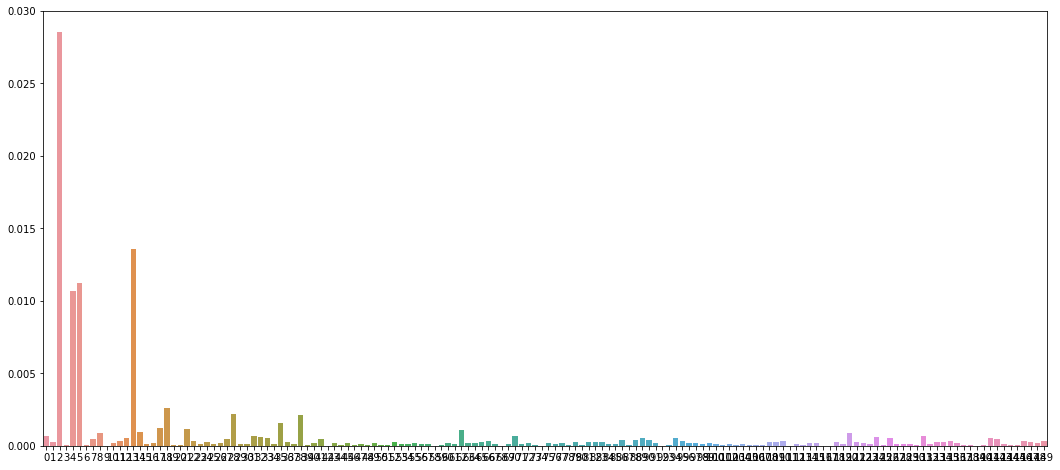

In [16]:
perm = PermutationImportance(dt, random_state=1).fit(data_reduced, target)

plt.figure(figsize=(18,8))
sn.barplot(x=np.arange(len(perm.feature_importances_)), y=perm.feature_importances_)
plt.show()

In [19]:
np.where((dt.feature_importances_ < 0.001) & (perm.feature_importances_ < 0.001))

(array([  6,   9,  19,  42,  48,  58,  59,  68,  74,  78,  80,  87,  92,
         93, 101, 106, 107, 111, 113, 116, 117, 125, 128, 138, 139, 140,
        145], dtype=int64),)

In [21]:
important_cols = np.where((dt.feature_importances_ >= 0.001) | (perm.feature_importances_ >= 0.001))[0]

important_cols.shape

(123,)

In [23]:
data_reduced = data_reduced[:, important_cols]
test_data_reduced = test_data_reduced[:, important_cols]

data_reduced.shape

(198444, 123)

## Resampling

데이터를 확인 해보면 클래스가 0인 데이터가 1인 데이터일 때 보다 훨씬 많은 것을 알 수 있다. 이런 데이터를 비대칭 데이터라 한다. 데이터가 비대칭일 경우 분류기가 다수 클래스에 대한 확률을 과대평가 할 가능성이 크기 때문에 Resampling을 통해 어느정도 대칭적으로 데이터를 만들어야 할 필요가 있다. Resampling 에는 데이터의 개수를 늘리는 Oversampling 과 줄이는 Undersampling 이 있다. 이번 데이터의 경우 크기가 매우 커 데이터를 다루는데 실행시간이 오래 걸리는 문제도 있으므로 데이터를 줄일 필요가 있다. 따라서 Undersampling 을 사용한다.

Undersampling 에는 여러 알고리즘이 존재한다. 가장 단순한 방법으로는 다수 클래스 데이터 중 일부를 무작위로 골라 삭제하는 것이다. 그러나 이 방법은 속도는 빠르지만 대신 모델의 예측력에 도움을 줄 수 있는 중요한 데이터를 잃을 수 있기 때문에 CondensedNearestNeighbour 방법을 사용한다. [참고](https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html#tomeks-link-method)

다양한 Resampling 알고리즘은 imbalanced-learn 라이브러리에 있다.

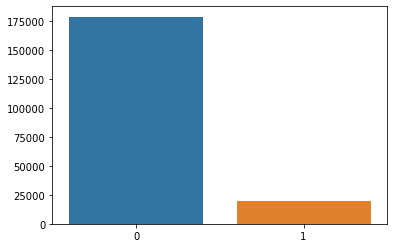

In [30]:
sn.barplot(x=[0, 1], y=[(target == 0).sum(), (target == 1).sum()])
plt.show()

In [1]:
data_resampled, target_resampled = TomekLinks(n_jobs=4).fit_resample(data_reduced, target)

sn.barplot(x=[0, 1], y=[(target_resampled == 0).sum(), (target_resampled == 1).sum()])
plt.show()

NameError: name 'TomekLinks' is not defined

In [ ]:
np.save("data_resampled.npy", data_resampled)
np.save("target_resampled.npy", target_resampled)